In [93]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report, precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

In [94]:
df = pd.read_csv('draftProspects.csv')
picks = pd.read_parquet("draft_picks.parquet")
df

,Player,Player Bio,Player Grades,Draft Class,Link
0,Jadeveon Clowney,A physical specimen with a rare size-speed com...,7.50,2014,https://www.nfl.com/prospects/jadeveon-clowney...
1,Sammy Watkins,A legitimate No. 1-caliber receiver who steppe...,7.10,2014,https://www.nfl.com/prospects/sammy-watkins/32...
2,Anthony Barr,"A highly disruptive, athletic specimen with th...",7.00,2014,https://www.nfl.com/prospects/anthony-barr/320...
3,Khalil Mack,A havoc-wreaking rush linebacker with the burs...,7.00,2014,https://www.nfl.com/prospects/khalil-mack/3200...
4,Jake Matthews,"Smart, tough, versatile franchise left tackle ...",7.00,2014,https://www.nfl.com/prospects/jake-matthews/32...
...,...,...,...,...,...
4377,Zeke Vandenburgh,It might be easy to discount Vandenburgh‚Äôs p...,5.82,2023,https://www.nfl.com/prospects/zeke-vandenburgh...
4378,Ben VanSumeren,VanSumeren‚Äôs production and game tape won‚Äô...,5.66,2023,https://www.nfl.com/prospects/ben-vansumeren/3...
4379,Taron Vincent,Vincent is smallish for the interior and lacks...,5.59,2023,https://www.nfl.com/prospects/taron-vincent/32...
4380,BJ Wilson,"A tackle prospect with NFL measurables, Wilson...",5.64,2023,https://www.nfl.com/prospects/bj-wilson/320057...


In [95]:
# Example of a full player Bio
df["Player Bio"][0]

'A physical specimen with a rare size-speed combination, Clowney was not as impactful as a junior while playing through injuries and being forced to deal with opposing offenses that fully accounted for him with extra chip protection. Was a 20-year-old junior affected by turnover on the defensive coaching staff. Could benefit tremendously from a stable positional coach and strong, veteran mentor on the defensive line who will hold him accountable, show him the way and serve as a fatherly figure. Is one of the most unique talents in the draft and could easily be a double-digit sack producer in the pros from either end. Is every bit worthy of the first overall pick -- will immediately upgrade a defensive line and improve the production of those around him.'

In [96]:
#take log length of bio and normalize it
df['bioLength'] = df["Player Bio"].apply(lambda x: np.log(len(str(x))))
bio_length = df['bioLength'].values.reshape(-1, 1)
scaler = StandardScaler()
bio_length_normalized = scaler.fit_transform(bio_length)
df['bio_length_normalized'] = bio_length_normalized

In [97]:
# Function to convert POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if not found

In [98]:
#How to Preprocess the words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(bio):
    tokenized_text = word_tokenize(bio) #tokenize
    tokenized_text = [w.lower() for w in tokenized_text] #lowercase
    tokenized_text = [w for w in tokenized_text if not w in stop_words] #remove stop words
    pos_tags = pos_tag(tokenized_text) #Need to pass in part of speech
    tokenized_text = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags] #lemmatize
    return " ".join(tokenized_text)

df["Preprocessed Bio"] = df['Player Bio'].apply(preprocess)

In [99]:
#Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
sentiments = []
for text in df['Player Bio']: 
    sentiment_score = analyzer.polarity_scores(text)
    sentiments.append(sentiment_score['compound'])
sentiments = np.array(sentiments)
df["sentiments"] = sentiments

#convert it to numeric values
df['Player Grades'] = df['Player Grades'].astype(float)
player_grades = df['Player Grades']

In [100]:
#Find correlations
df[["bio_length_normalized", "Player Grades", "sentiments"]].corr()

,bio_length_normalized,Player Grades,sentiments
bio_length_normalized,1.000000,0.209531,-0.018603
Player Grades,0.209531,1.000000,0.102724
sentiments,-0.018603,0.102724,1.000000


In [101]:
grades = df['Player Grades']
df = df[["Preprocessed Bio", "bio_length_normalized", "sentiments", "Player", "Draft Class"]] #only keep important ones for now in terms of X
df #Updated df

,Preprocessed Bio,bio_length_normalized,sentiments,Player,Draft Class
0,physical specimen rare size-speed combination ...,0.307687,0.9354,Jadeveon Clowney,2014
1,legitimate . 1-caliber receiver step onto fiel...,-0.937056,0.8625,Sammy Watkins,2014
2,"highly disruptive , athletic specimen pass-rus...",-0.645786,0.0627,Anthony Barr,2014
3,havoc-wreaking rush linebacker burst accelerat...,-0.425757,0.6124,Khalil Mack,2014
4,"smart , tough , versatile franchise leave tack...",-1.633452,0.9313,Jake Matthews,2014
...,...,...,...,...,...
4377,might easy discount vandenburgh‚äôs production...,-0.414645,0.9516,Zeke Vandenburgh,2023
4378,vansumeren‚äôs production game tape won‚äôt dr...,-0.662501,0.9161,Ben VanSumeren,2023
4379,"vincent smallish interior lack ideal length , ...",-1.884458,0.5023,Taron Vincent,2023
4380,"tackle prospect nfl measurables , wilson lack ...",-0.748307,0.1768,BJ Wilson,2023


## Predict Player Grades

In [102]:
#Split data
X = df.drop(columns=["Player", "Draft Class"])

X_train, X_test, y_train, y_test = train_test_split(X, player_grades, test_size=0.2, random_state=42)

In [103]:
def extract_features(preprocessed_text_train, preprocessed_text_test,ngram_range=(1,2)):
    #Use Tfidf
    vectorizer=TfidfVectorizer(ngram_range=ngram_range) 
    train_features=vectorizer.fit_transform(preprocessed_text_train)
    test_features =vectorizer.transform(preprocessed_text_test)
    
    return train_features, test_features

In [104]:
#run tfidf
train_features, test_features = extract_features(X_train['Preprocessed Bio'], X_test['Preprocessed Bio'])

In [105]:
X_train = X_train.drop(columns=["Preprocessed Bio"])
X_test = X_test.drop(columns=["Preprocessed Bio"])

In [106]:
X_train_df_sparse = csr_matrix(X_train.values)
X_test_df_sparse = csr_matrix(X_test.values)

#Combine them all now using hstack
X_train = hstack([train_features, X_train_df_sparse])
X_test = hstack([test_features, X_test_df_sparse])

Optimal Alpha from Cross-Validation: 0.1


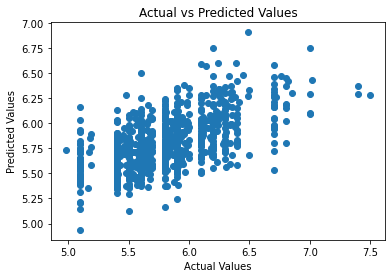

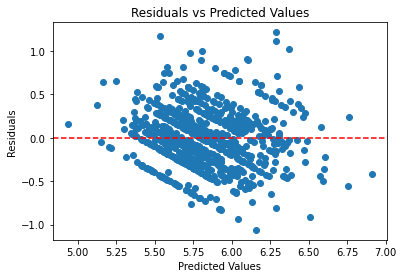

Root Mean Squared Error: 0.3264245182580533
R^2 score: 0.334398769820372


In [107]:
# Create a RidgeCV model
ridge_cv = RidgeCV(alphas=[0.05, 0.1, 1.0, 10.0])
ridge_cv.fit(X_train, y_train)

# Get the optimal alpha value from cross-validation
optimal_alpha = ridge_cv.alpha_

# Make predictions on the test set with the RidgeCV model
y_pred_ridge_cv = ridge_cv.predict(X_test)

# Evaluate the RidgeCV model
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = mse_ridge_cv ** 0.5
r2_ridge = r2_score(y_test, y_pred_ridge_cv)

print("Optimal Alpha from Cross-Validation:", optimal_alpha)
plt.scatter(y_test, y_pred_ridge_cv)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

# Analyze residuals
residuals = y_test - y_pred_ridge_cv

# Plot residuals
plt.scatter(y_pred_ridge_cv, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()

# Other statistics and plot
print("Root Mean Squared Error:", rmse_ridge_cv)
print("R^2 score:", r2_ridge)

In [108]:
#Compared to dummy regressor
dummy_regressor = DummyRegressor(strategy='median') #better than median

# Fit the dummy regressor to the training data
dummy_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dummy = dummy_regressor.predict(X_test)

# Evaluate the dummy regressor
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print("Root Mean Squared Error (Dummy):", mse_dummy ** 0.5)

Root Mean Squared Error (Dummy): 0.4002309766417712


# Predict Draft Round

In [109]:
df = pd.merge(df, picks, left_on=["Player", "Draft Class"], right_on=["pfr_player_name", "season"], how="inner")
firstRound = (df['round'] == 1).astype(int)
round = df["round"]
topRound = (df['round'] <= 3).astype(int)

In [110]:
#use these 2 columns for my testing
combined_df = pd.concat([round, topRound], axis=1)
combined_df.columns = ['round', 'topRound']

In [111]:
#columns to drop
dropColumns = ["Player", "Draft Class"] + list(picks.columns)
X = df.drop(columns=dropColumns)
print(X.columns)

Index(['Preprocessed Bio', 'bio_length_normalized', 'sentiments'], dtype='object')


In [112]:
round.value_counts()

round
3    372
4    349
5    341
6    339
1    306
2    305
7    291
Name: count, dtype: int64

In [113]:
topRound.value_counts()

round
0    1320
1     983
Name: count, dtype: int64

In [114]:
#multi-classification now: logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, combined_df, test_size=0.2, random_state=42)

In [115]:
#run tfidf
train_features, test_features = extract_features(X_train['Preprocessed Bio'], X_test['Preprocessed Bio'])
X_train = X_train.drop(columns=["Preprocessed Bio"])
X_test = X_test.drop(columns=["Preprocessed Bio"])
X_train_df_sparse = csr_matrix(X_train.values)
X_test_df_sparse = csr_matrix(X_test.values)

#Combine them all now using hstack (sparse matrices now)
X_train = hstack([train_features, X_train_df_sparse])
X_test = hstack([test_features, X_test_df_sparse])

In [116]:
# functiont to print results of the model
def resultsDraftRound(model, y_train, y_test):
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)

    confusion = confusion_matrix(y_test, y_test_pred)

    # Calculate the macro F1 score
    f1 = f1_score(y_test, y_test_pred, average = "macro")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred)

    # Print the results
    print("Confusion Matrix:")
    print(confusion)
    print("\nMacro F1 Score:", f1)
    print("\nAccuracy:", accuracy)

## Multi-Class classification (draft round)

In [117]:
logreg = LogisticRegression(multi_class='auto', solver='sag') 
resultsDraftRound(logreg, y_train["round"], y_test["round"])

Confusion Matrix:
[[31  7 10  5  3  5  1]
 [28  2 13  1 10  5  4]
 [ 4  8 26 10 11  6  4]
 [ 9  1 21 11 14 13  4]
 [ 6  2 16  7  9  7 13]
 [ 7  3 16 11 15 12  8]
 [ 7  1 16  8 11 16  3]]

Macro F1 Score: 0.18195249281585815

Accuracy: 0.2039045553145336


In [118]:
#Dummy classifier
dummy=DummyClassifier(strategy='stratified')
resultsDraftRound(dummy, y_train["round"], y_test["round"])

Confusion Matrix:
[[ 6 16  5 11 11  8  5]
 [ 9  6 16  6 10  9  7]
 [11  6  9 15 10  7 11]
 [ 8  9 15  9 11 12  9]
 [12 12 12  8  9  6  1]
 [11  7 13 12 14 10  5]
 [11  4  7 13 12  8  7]]

Macro F1 Score: 0.12133549329521558

Accuracy: 0.12147505422993492


In [119]:
#Dummy classifier
dummy=DummyClassifier(strategy='most_frequent')
resultsDraftRound(dummy, y_train["round"], y_test["round"])

Confusion Matrix:
[[ 0  0 62  0  0  0  0]
 [ 0  0 63  0  0  0  0]
 [ 0  0 69  0  0  0  0]
 [ 0  0 73  0  0  0  0]
 [ 0  0 60  0  0  0  0]
 [ 0  0 72  0  0  0  0]
 [ 0  0 62  0  0  0  0]]

Macro F1 Score: 0.03719676549865229

Accuracy: 0.14967462039045554


## Binary Classification (top 3 rounds or not)

In [120]:
#logistic regression
logreg = LogisticRegression() 
resultsDraftRound(logreg, y_train["topRound"], y_test["topRound"])

Confusion Matrix:
[[230  37]
 [114  80]]

Macro F1 Score: 0.6336668052478409

Accuracy: 0.6724511930585684


In [121]:
#both dummy classifiers below
dummy=DummyClassifier(strategy='stratified')
resultsDraftRound(dummy, y_train["topRound"], y_test["topRound"])

Confusion Matrix:
[[151 116]
 [122  72]]

Macro F1 Score: 0.4681113050222998

Accuracy: 0.4837310195227766


In [122]:
dummy=DummyClassifier(strategy='most_frequent')
resultsDraftRound(dummy, y_train["topRound"], y_test["topRound"])

Confusion Matrix:
[[267   0]
 [194   0]]

Macro F1 Score: 0.3667582417582418

Accuracy: 0.579175704989154


# Looking at how HOF status relates to qbs

In [123]:
picks

,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,pfr_player_name,hof,position,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
0,1980,1,1,DET,,SimsBi00,billy-sims-1,Billy Sims,False,RB,...,0.0,1131.0,5106.0,42.0,186.0,2072.0,5.0,NaN,NaN,NaN
1,1980,1,2,NYJ,,JoneLa00,lam-jones-1,Lam Jones,False,WR,...,0.0,9.0,17.0,0.0,138.0,2322.0,13.0,NaN,NaN,NaN
2,1980,1,3,CIN,,MunoAn00,,Anthony Munoz,True,T,...,0.0,0.0,0.0,0.0,7.0,18.0,4.0,NaN,NaN,NaN
3,1980,1,4,GNB,,ClarBr23,bruce-clark-1,Bruce Clark,False,DE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,39.5
4,1980,1,5,BAL,,DickCu00,curtis-dickey-1,Curtis Dickey,False,RB,...,0.0,937.0,4019.0,32.0,134.0,1577.0,8.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12151,2023,7,255,SFO,None,GrahJa02,jalen-graham-1,Jalen Graham,False,SAF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12152,2023,7,256,GNB,None,DuboGr00,None,Grant Dubose,False,WR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12153,2023,7,257,DEN,None,ForsAl00,alex-forsyth-1,Alex Forsyth,False,OL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12154,2023,7,258,CHI,None,WillKe07,None,Kendall Williamson,False,SAF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
qbs = picks[picks['position'] == 'QB']

#remove players who have not retired yet
qbs = qbs[qbs['season'] < 2000] #this is for year they were drafted

In [125]:
qbs['hof'].value_counts()

hof
False    273
True       6
Name: count, dtype: int64

In [126]:
qbs['hof'] = qbs['hof'].astype(int)

#Fill Null values of total touchdown passes
qbs['pass_tds'].fillna(0, inplace=True)
qbs['pass_tds']

14       86.0
27       60.0
36        0.0
84       55.0
88        1.0
        ...  
5903    123.0
5923      0.0
5999      1.0
6011      1.0
6017      0.0
Name: pass_tds, Length: 279, dtype: float64

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


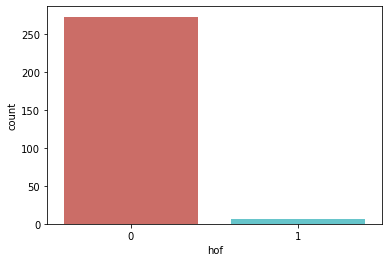

In [127]:
sns.countplot(x='hof', data = qbs, palette='hls')
plt.show()

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


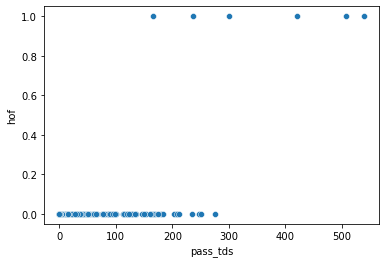

In [128]:
#Scatterplot of hall of fame status vs. total touchdowns
sns.scatterplot(y="hof", x = "pass_tds", data = qbs)
plt.show()

In [129]:
#Run logistic regression
#test on itself

X = qbs[['pass_tds']]
y = qbs['hof']

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X, y)

# Make predictions on the test data
y_pred = model.predict(X)

# Evaluate the model's accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y, y_pred))

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       273
           1       1.00      0.67      0.80         6

    accuracy                           0.99       279
   macro avg       1.00      0.83      0.90       279
weighted avg       0.99      0.99      0.99       279



/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


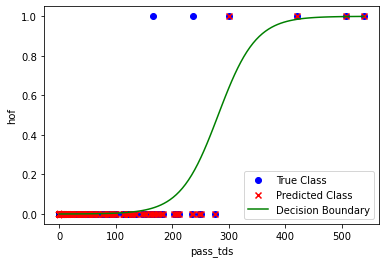

In [130]:
# Plot the data points and decision boundary
plt.scatter(X, y, color='blue', label='True Class')
plt.scatter(X, y_pred, color='red', marker='x', label='Predicted Class')
plt.xlabel('pass_tds')
plt.ylabel('hof')
plt.legend()

# Create a range of values for the x-axis
x_range = np.linspace(X.min(), X.max(), num=100)
# Calculate the corresponding y-values using the logistic regression model's decision boundary
y_range = model.predict_proba(x_range.reshape(-1, 1))[:, 1]

# Plot the decision boundary
plt.plot(x_range, y_range, color='green', label='Decision Boundary')
plt.legend()

plt.show()


In [131]:
#Who were the exceptions
hofers = qbs[qbs['hof'] == 1]
hofers[['season', 'pfr_player_name', 'pass_ints', 'pass_yards', 'pass_tds', 'allpro', 'probowls', 'seasons_started']].sort_values('pass_tds')

,season,pfr_player_name,pass_ints,pass_yards,pass_tds,allpro,probowls,seasons_started
3007,1989,Troy Aikman,141.0,32942.0,165.0,0,6,12
1012,1983,Jim Kelly,175.0,35467.0,237.0,1,5,11
999,1983,John Elway,226.0,51475.0,300.0,0,9,16
1025,1983,Dan Marino,252.0,61361.0,420.0,3,9,16
3705,1991,Brett Favre,336.0,71838.0,508.0,3,11,19
5532,1998,Peyton Manning,251.0,71940.0,539.0,7,14,17


So Troy Aikman and Jim Kelly made the Hall of Fame as quarterbacks, but seem to be the less deserving, particularly Troy Aikman